# New Section

In [1]:
!pip install biopython
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.6 MB/s eta 0:00:00


In [48]:
import pandas as pd
reactions = pd.read_csv('Reaction_base.csv')
exclude = pd.read_csv('Reaction_TXTL.csv')
reactions = reactions[~reactions['Reaction ID'].isin(exclude['Reaction ID'])].reset_index()


In [28]:
# prompt: make a function that parses the output of REST.kegg_get('ec:1.1.1.100').read() between PATHWAY and ORTHODOLOGY for ids such as ec00061. the easiest way would be to look for all the ec00061 ids
ec_cache = {}
from Bio.KEGG import REST
def get_pathways(ec_number):
    if ec_number in ec_cache:
        return ec_cache[ec_number]
    else:
        pathways = []
        record = REST.kegg_get(ec_number).read()
        start = record.find('PATHWAY')
        end = record.find('ORTHOLOGY')
        relevant_text = record[start:end]
        for line in relevant_text.split('\n'):
            if 'ec' in line:
                index = 0 if 'PATHWAY' not in line else 1
                pathway_id = line.strip().split()[index]
                pathways.append(pathway_id)
        ec_cache[ec_number] = pathways
        return pathways


In [29]:
info = []
for ec in reactions['EC']:
    for p in get_pathways(ec):
        if 'ec' in p:
            info.append([ec, p, get_pathway_name(p)])

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(info, columns=['EC', 'Pathway', 'Pathway Name']).to_csv('EC_to_KEGGpathway.csv',index=False)

In [ ]:
import numpy as np

pathway_cache = {}
for n in np.unique([i[1] for i in info]):
    for i in info:
        if i[1] == n:
            pathway_cache[n] = i[2]

In [30]:
patways = [get_pathways(ec) for ec in reactions['EC']]

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
metabolites_keep = ['C00022', 'C00065', 'C00036', 'C00149']
reactants = reactions['Products'] +'; '+ reactions['Substrates']
reactions_keep = np.unique(sum([list(np.where([m in r for r in reactants])[0]) for m in metabolites_keep],[]))

pathways_keep = ['ec00020', 'ec00010', 'ec00620', 'ec00030', 'ec00061']

sum([np.any([p in ps for p in pathways_keep[:1]]) for ps in patways])

37

In [ ]:
for pk in pathways_keep:
    print(f"Pathway name for {pk}: {get_pathway_name(pk)}")
    print(sum([pk in p for p in patways]))

    print(sum([r in np.where([pk in p for p in patways])[0] for r in reactions_keep]))

Pathway name for ec00020: Citrate cycle (TCA cycle)
37
7
Pathway name for ec00010: Glycolysis / Gluconeogenesis
88
14
Pathway name for ec00620: Pyruvate metabolism
71
21
Pathway name for ec00030: Pentose phosphate pathway
45
2
Pathway name for ec00061: Fatty acid biosynthesis
39
0


In [33]:
u, c = np.unique(sum(patways,[]),return_counts=True)
uc_dict = {u:c for u,c in zip(u,c)}

In [12]:
ur_dict = {u:c for u,c in zip(u[np.argsort(c)],rs_in_ecs)}
ur_dict['ec00061']

NameError: name 'rs_in_ecs' is not defined

In [34]:
# prompt: get the name of the pathway from the REST kegg get output. make sure no other information is retrieved
pathway_cache = {}
def get_pathway_name(pathway_id):
    try:
        return pathway_cache[pathway_id]
    except KeyError:
        record = REST.kegg_get(pathway_id).read()
        start = record.find('NAME') + 5  # Add 5 to skip "NAME\t"
        end = record.find('\n', start)    # Find the end of the line
        name =record[start:end].strip()  # Extract and trim the name
        pathway_cache[pathway_id] = name
        return name

# Example usage
pathway_id = "ec00010"  # Replace with actual pathway ID
name = get_pathway_name(pathway_id)
print(name)


Glycolysis / Gluconeogenesis


In [35]:
rs_in_ecs = []
for p in u[np.argsort(c)]:
    rs_in_ecs.append(sum([r in np.where([p in ps for ps in patways])[0] for r in reactions_keep]))

In [ ]:
for p,val in zip(u[np.argsort(c)][np.argsort(rs_in_ecs)[-40:]], np.array(rs_in_ecs)[np.argsort(rs_in_ecs)[-40:]]):
    print(f"Pathway name for {p}: {get_pathway_name(p)}")
    print(val)
    print(uc_dict[p])

Pathway name for ec00040: Pentose and glucuronate interconversions
0
7
Pathway name for ec00604: Glycosphingolipid biosynthesis - ganglio series
0
7
Pathway name for ec00860: Porphyrin metabolism
0
7
Pathway name for ec00946: Degradation of flavonoids
0
6
Pathway name for ec00523: Polyketide sugar unit biosynthesis
0
6
Pathway name for ec01051: Biosynthesis of ansamycins
0
6


HTTPError: HTTP Error 400: Bad Request

In [36]:
important_ecs = np.array(list(u[np.argsort(c)][np.argsort(rs_in_ecs)][-26:-3][::-1]) + ['ec00061'])

num_r = []
for i in range(len(important_ecs)):
    keep=important_ecs[:i+1]
    num_r.append((len(np.unique(sum([list(np.where([k in ps for ps in patways])[0]) for k in keep],[])))))

In [ ]:
labels = [get_pathway_name(x) for x in important_ecs[::-1]]+['CORE']

<ipython-input-77-784ff69cc623>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  f.tight_layout()


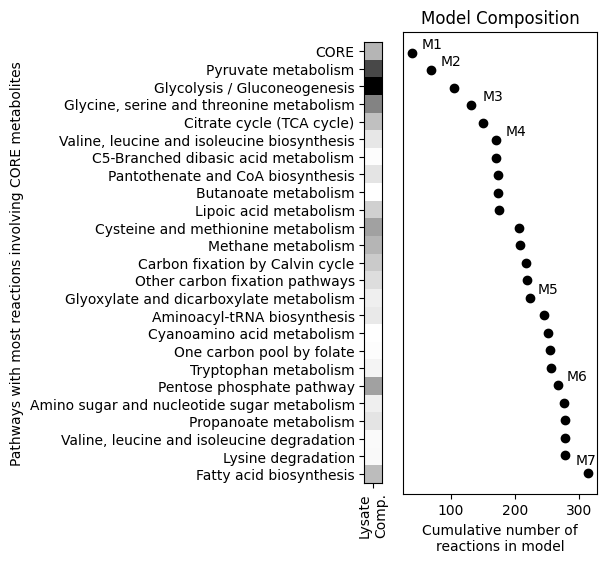

In [ ]:
f, (a0, a1) = plt.subplots(1, 2, width_ratios=[1, 11],figsize=(3,6))
a1.plot([*num_r[::-1],len(reactions_keep)],range(len(num_r)+1),'ok')
a0.set_yticks(range(len(num_r)+1),labels[::-1], rotation=0);
a0.set_xticks([0],['Lysate\nComp.'], rotation=90);

a0.imshow(np.expand_dims(np.array([len(reactions_keep)]+[uc_dict[c] for c in important_ecs]),1), cmap='Greys')

a1.set_yticks([]);
a1.set_xlabel('Cumulative number of\nreactions in model')
a0.set_ylabel('Pathways with most reactions involving CORE metabolites')

a1.text(55, len(important_ecs)+0.25,'M1');
a1.text(85, len(important_ecs)+0.25-1,'M2');
a1.text(150, len(important_ecs)+0.25-3,'M3');
a1.text(185, len(important_ecs)+0.25-5,'M4');
a1.text(235, len(important_ecs)+0.25-14,'M5');
a1.text(280, len(important_ecs)+0.25-19,'M6');
a1.text(295, 0.5,'M7');
a1.set_title('Model Composition')
f.tight_layout()

In [37]:
indexes = [1,3,5,14,19,24]
ecs_keep = [important_ecs[:i] for i in indexes]

In [38]:
reactions_M = [reactions_keep]

for ecs in ecs_keep:
    reactions_M.append(np.unique(sum([list(np.where([k in ps for ps in patways])[0]) for k in ecs],[])))

In [49]:
[reactions.loc[r].to_csv('Reactions_M'+str(i+1)+'.csv',index=False) for i,r in enumerate(reactions_M)]

[None, None, None, None, None, None, None]

In [ ]:
len(reactions.loc[reactions_M[2]])

132

In [ ]:
# prompt: get the name if the enzyme from the REST kegg get output

def get_enzyme_name(ec_number):
    record = REST.kegg_get(ec_number).read()
    start = record.find('NAME')
    end = record.find('CLASS')
    name_text = record[start:end].strip()
    name_lines = name_text.split('\n')
    name = name_lines[0].split()[1:]  # Remove the "NAME" keyword and take the rest
    return ' '.join(name)

# Example usage
for ec_number in np.unique(reactions['EC'].loc[np.where([len(p)==0 for p in patways])]):
    enzyme_name = get_enzyme_name(ec_number)
    print(f"Enzyme name for EC {ec_number}: {enzyme_name}")


Enzyme name for EC 1.15.1.1: superoxide dismutase;
Enzyme name for EC 1.20.4.1: arsenate reductase (glutathione/glutaredoxin);
Enzyme name for EC 1.5.3.2: N-methyl-L-amino-acid oxidase;
Enzyme name for EC 1.8.4.12: peptide-methionine (R)-S-oxide reductase;
Enzyme name for EC 2.1.1.172: 16S rRNA (guanine1207-N2)-methyltransferase;
Enzyme name for EC 2.1.1.33: tRNA (guanine46-N7)-methyltransferase;
Enzyme name for EC 2.7.3.9: phosphoenolpyruvate---protein phosphotransferase;
Enzyme name for EC 2.7.7.56: tRNA nucleotidyltransferase;
Enzyme name for EC 2.7.7.6: DNA-directed RNA polymerase;
Enzyme name for EC 2.7.7.7: DNA-directed DNA polymerase;
Enzyme name for EC 2.7.7.8: polyribonucleotide nucleotidyltransferase;
Enzyme name for EC 3.1.1.29: peptidyl-tRNA hydrolase;
Enzyme name for EC 3.1.3.23: sugar-phosphatase
Enzyme name for EC 3.5.1.88: peptide deformylase;
Enzyme name for EC 3.6.4.13: Transferred to 5.6.2.5 and 5.6.2.6 and 5.6.2.7
Enzyme name for EC 5.2.1.8: peptidylprolyl isomerase